# Notebook 6: Long-Context Phase Transition

**Duration**: 2-3 hours  
**Prerequisites**: Notebook 5

This notebook explores what happens when sequence length $n$ grows large. The paper reveals a **phase transition** at $\beta \sim \log n$—below this threshold, attention becomes uniform and useless.

---

## Learning Objectives

By the end of this notebook, you should be able to:

- [ ] Understand why long sequences flatten attention
- [ ] Derive the critical scaling $\beta \sim \log n$
- [ ] Interpret Theorem 7's three regimes
- [ ] Connect to practical long-context models

---

## Connection to Your Work

Relevant when building vector databases over large biological knowledge graphs. If you're using context windows with many entities, the scaling of attention matters for maintaining semantic structure.

In [1]:
# Core imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, Markdown
from scipy.special import softmax

# Visualization setup
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

# Import our utilities
from utils import (
    random_sphere_points,
    attention_weights,
    simulate_sa,
    compute_cluster_metric,
    pairwise_similarity_dist
)

np.random.seed(42)
print("Imports loaded successfully!")

Imports loaded successfully!


---

## 1. The Long-Context Problem

### Why Long Sequences Are Hard

Consider the softmax attention weights:

$$A_{ij} = \frac{\exp(\beta \langle x_i, x_j \rangle)}{\sum_{k=1}^n \exp(\beta \langle x_i, x_k \rangle)}$$

As $n \to \infty$ with fixed $\beta$:
- The denominator grows ~ $n$
- Each weight $A_{ij} \to 1/n$
- Attention becomes **uniform** (every token equals every other)

### Uniform Attention = Useless

If all weights equal $1/n$:
- No discrimination between tokens
- Dynamics become trivial
- Fast collapse to a single point

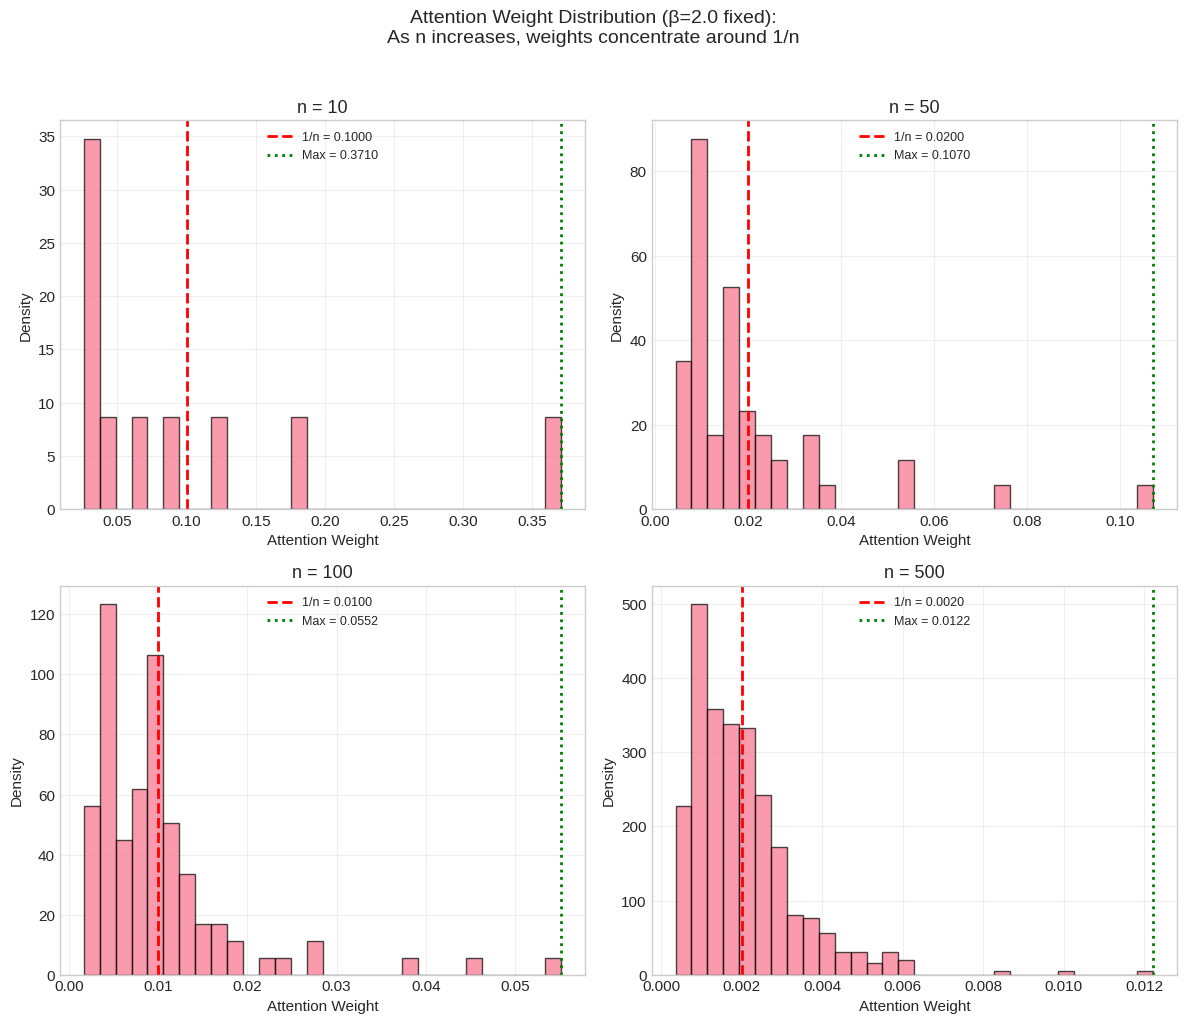

Observation: With fixed β, increasing n makes attention nearly uniform.
This is problematic—we lose the ability to discriminate between tokens!


In [2]:
# Demonstrate attention flattening with increasing n

beta = 2.0  # Fixed temperature
d = 10
n_values = [10, 50, 100, 500]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, n in enumerate(n_values):
    # Generate random particles
    X = random_sphere_points(n, d, seed=42)
    
    # Compute attention weights for first particle
    A = attention_weights(X, beta, normalized=True)
    weights = A[0]  # First row: attention from particle 0
    
    ax = axes[idx]
    ax.hist(weights, bins=30, density=True, alpha=0.7, edgecolor='black')
    ax.axvline(x=1/n, color='r', linestyle='--', linewidth=2, label=f'1/n = {1/n:.4f}')
    ax.axvline(x=np.max(weights), color='g', linestyle=':', linewidth=2, label=f'Max = {np.max(weights):.4f}')
    
    ax.set_xlabel('Attention Weight', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(f'n = {n}', fontsize=13)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle(f'Attention Weight Distribution (β={beta} fixed):\nAs n increases, weights concentrate around 1/n', 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("Observation: With fixed β, increasing n makes attention nearly uniform.")
print("This is problematic—we lose the ability to discriminate between tokens!")

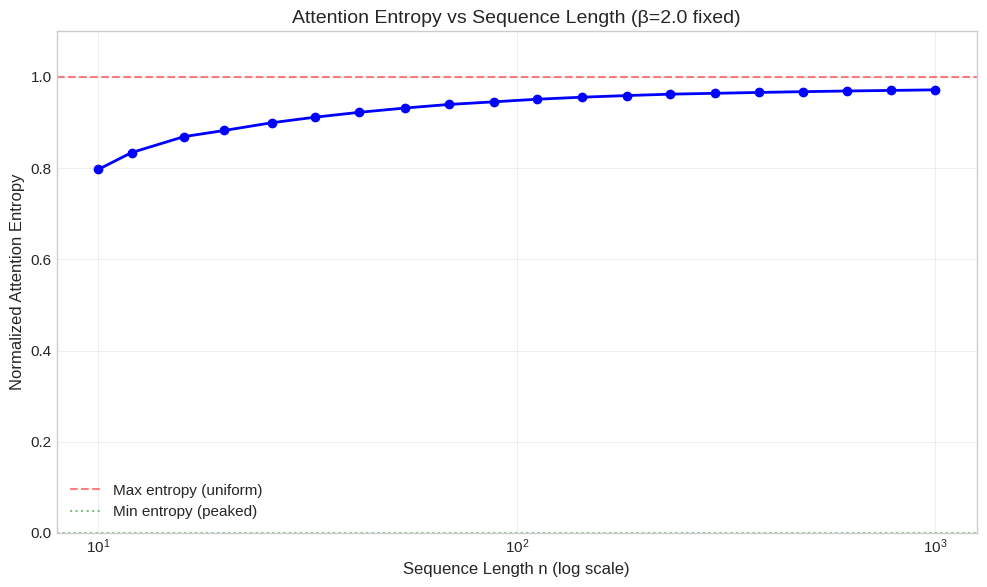

At n=10: entropy = 0.797
At n=1000: entropy = 0.972

Entropy approaching 1.0 = nearly uniform attention = bad!


In [3]:
# Measure attention entropy vs n

def attention_entropy(weights):
    """Compute entropy of attention distribution (normalized to [0, 1])."""
    weights = weights + 1e-10  # Avoid log(0)
    entropy = -np.sum(weights * np.log(weights))
    max_entropy = np.log(len(weights))  # Uniform distribution
    return entropy / max_entropy  # Normalized entropy

beta = 2.0
d = 10
n_range = np.logspace(1, 3, 20).astype(int)  # 10 to 1000

entropies = []
for n in n_range:
    X = random_sphere_points(n, d, seed=42)
    A = attention_weights(X, beta, normalized=True)
    # Average entropy across all particles
    avg_entropy = np.mean([attention_entropy(A[i]) for i in range(n)])
    entropies.append(avg_entropy)

fig, ax = plt.subplots(figsize=(10, 6))
ax.semilogx(n_range, entropies, 'bo-', linewidth=2, markersize=6)
ax.axhline(y=1.0, color='r', linestyle='--', alpha=0.5, label='Max entropy (uniform)')
ax.axhline(y=0.0, color='g', linestyle=':', alpha=0.5, label='Min entropy (peaked)')

ax.set_xlabel('Sequence Length n (log scale)', fontsize=12)
ax.set_ylabel('Normalized Attention Entropy', fontsize=12)
ax.set_title(f'Attention Entropy vs Sequence Length (β={beta} fixed)', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

print(f"At n=10: entropy = {entropies[0]:.3f}")
print(f"At n=1000: entropy = {entropies[-1]:.3f}")
print("\nEntropy approaching 1.0 = nearly uniform attention = bad!")

---

## 2. Logarithmic Scaling: $\beta \sim \log n$

### The Solution

To maintain useful attention as $n$ grows, scale $\beta$ with $n$:

$$\beta_n = \gamma \log n$$

This keeps attention weights meaningful:
- Higher n → higher β → sharper attention
- The ratio compensates for the growing denominator

### The Critical Parameter

The parameter $\gamma$ determines the regime:

| $\gamma$ | Regime | Behavior |
|----------|--------|----------|
| $\gamma < \frac{1}{1-\rho}$ | Subcritical | Uniform contraction → collapse |
| $\gamma = \frac{1}{1-\rho}$ | Critical | Sparse mixing → preserved structure |
| $\gamma > \frac{1}{1-\rho}$ | Supercritical | Identity-like → no interaction |

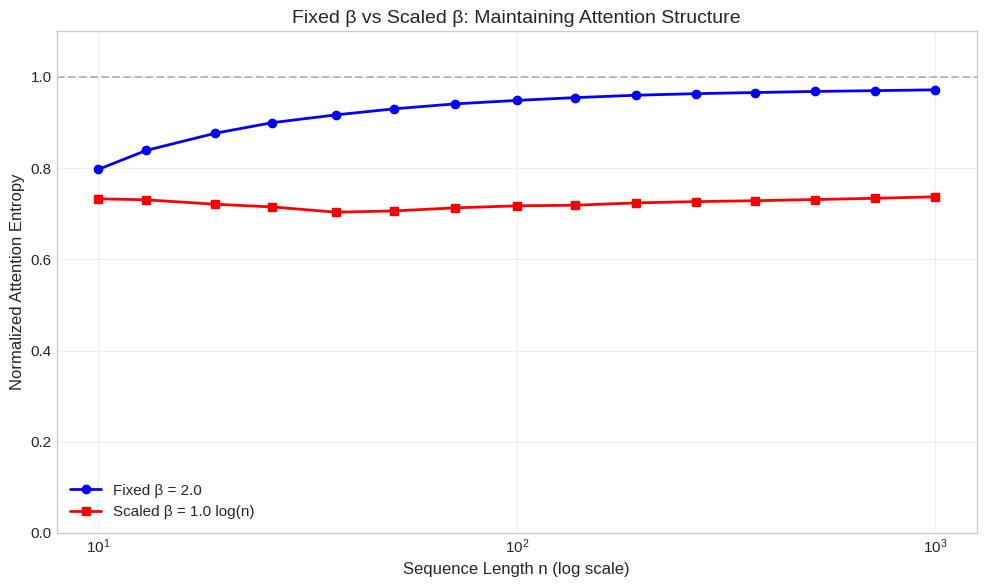

Key insight: Scaling β with log(n) keeps entropy bounded!
At n=1000:
  Fixed β: entropy = 0.972 (nearly uniform)
  Scaled β: entropy = 0.737 (meaningful structure)


In [4]:
# Demonstrate that β ~ log(n) maintains attention structure

d = 10
n_range = np.logspace(1, 3, 15).astype(int)  # 10 to 1000
gamma = 1.0  # β = γ log(n)

# Compare fixed β vs scaled β
entropies_fixed = []
entropies_scaled = []

beta_fixed = 2.0

for n in n_range:
    X = random_sphere_points(n, d, seed=42)
    
    # Fixed β
    A_fixed = attention_weights(X, beta_fixed, normalized=True)
    ent_fixed = np.mean([attention_entropy(A_fixed[i]) for i in range(n)])
    entropies_fixed.append(ent_fixed)
    
    # Scaled β = γ log(n)
    beta_scaled = gamma * np.log(n)
    A_scaled = attention_weights(X, beta_scaled, normalized=True)
    ent_scaled = np.mean([attention_entropy(A_scaled[i]) for i in range(n)])
    entropies_scaled.append(ent_scaled)

fig, ax = plt.subplots(figsize=(10, 6))
ax.semilogx(n_range, entropies_fixed, 'b-o', linewidth=2, markersize=6, label=f'Fixed β = {beta_fixed}')
ax.semilogx(n_range, entropies_scaled, 'r-s', linewidth=2, markersize=6, label=f'Scaled β = {gamma} log(n)')
ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)

ax.set_xlabel('Sequence Length n (log scale)', fontsize=12)
ax.set_ylabel('Normalized Attention Entropy', fontsize=12)
ax.set_title('Fixed β vs Scaled β: Maintaining Attention Structure', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

print("Key insight: Scaling β with log(n) keeps entropy bounded!")
print(f"At n=1000:")
print(f"  Fixed β: entropy = {entropies_fixed[-1]:.3f} (nearly uniform)")
print(f"  Scaled β: entropy = {entropies_scaled[-1]:.3f} (meaningful structure)")

---

## 3. Theorem 7: Three Regimes

### The Phase Transition

Theorem 7 characterizes behavior for $\beta_n = \gamma \log n$ as $n \to \infty$:

**Subcritical ($\gamma < \gamma_c$)**:
- Attention approaches uniform
- Fast collapse to single cluster
- No useful structure preserved

**Critical ($\gamma = \gamma_c$)**:
- Sparse mixing (each token interacts with few others)
- Structure preserved
- Interesting dynamics

**Supercritical ($\gamma > \gamma_c$)**:
- Attention becomes identity-like (self-attention dominates)
- No mixing between tokens
- No evolution

Where $\gamma_c = \frac{1}{1-\rho}$ depends on the typical correlation $\rho$.

Typical correlation ρ = -0.004
Critical γ_c = 1/(1-ρ) = 0.996


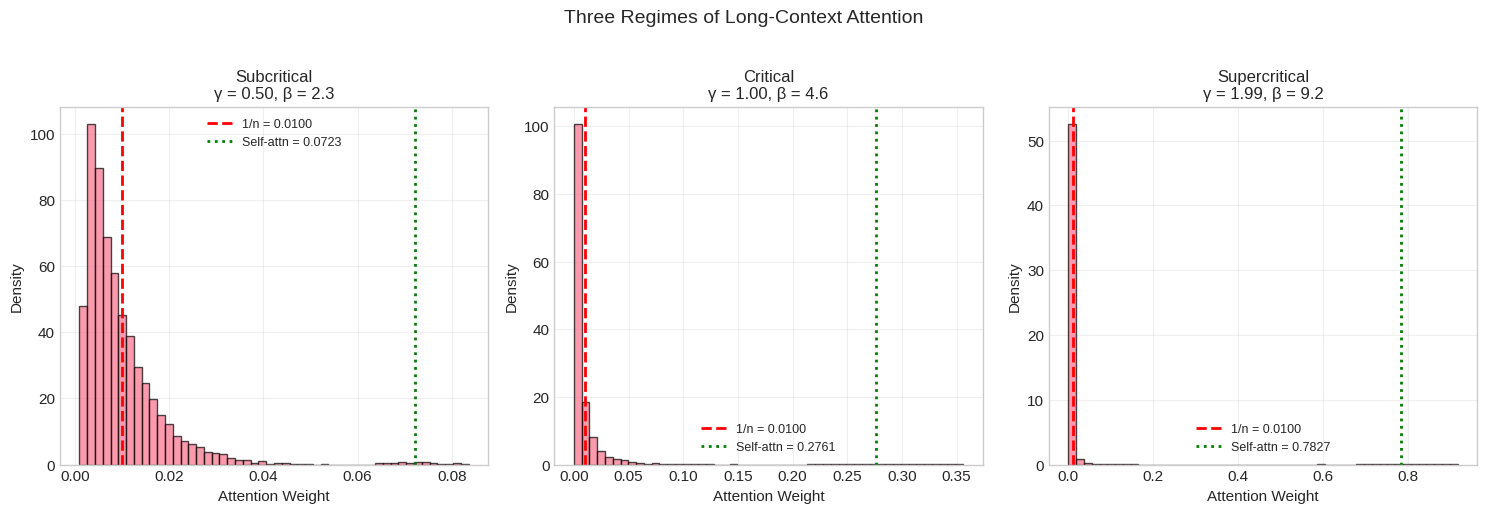


Observations:
  Subcritical: Weights cluster around 1/n (uniform)
  Critical: Structured distribution (useful)
  Supercritical: Self-attention dominates (no mixing)


In [5]:
# Demonstrate the three regimes

n = 100
d = 10
X = random_sphere_points(n, d, seed=42)

# Typical correlation
sims = pairwise_similarity_dist(X)
rho = np.mean(sims)
gamma_c = 1 / (1 - rho)

print(f"Typical correlation ρ = {rho:.3f}")
print(f"Critical γ_c = 1/(1-ρ) = {gamma_c:.3f}")

# Three γ values: subcritical, critical, supercritical
gammas = {
    'Subcritical': gamma_c * 0.5,
    'Critical': gamma_c,
    'Supercritical': gamma_c * 2.0
}

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (regime, gamma) in enumerate(gammas.items()):
    beta = gamma * np.log(n)
    A = attention_weights(X, beta, normalized=True)
    
    # Histogram of weights
    all_weights = A.flatten()
    
    ax = axes[idx]
    ax.hist(all_weights, bins=50, density=True, alpha=0.7, edgecolor='black')
    ax.axvline(x=1/n, color='r', linestyle='--', linewidth=2, label=f'1/n = {1/n:.4f}')
    
    # Diagonal (self-attention)
    diag_weights = np.diag(A)
    ax.axvline(x=np.mean(diag_weights), color='g', linestyle=':', linewidth=2, 
               label=f'Self-attn = {np.mean(diag_weights):.4f}')
    
    ax.set_xlabel('Attention Weight', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(f'{regime}\nγ = {gamma:.2f}, β = {beta:.1f}', fontsize=12)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Three Regimes of Long-Context Attention', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\nObservations:")
print("  Subcritical: Weights cluster around 1/n (uniform)")
print("  Critical: Structured distribution (useful)")
print("  Supercritical: Self-attention dominates (no mixing)")

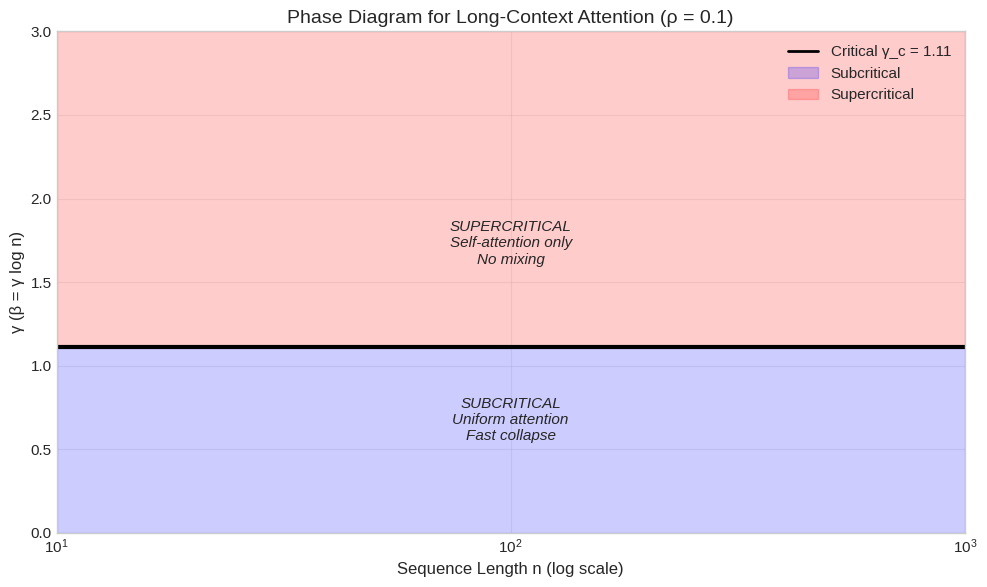

Critical point: γ_c = 1/(1-ρ) = 1.11 for ρ = 0.1
At the critical line, attention is sparse but structured.


In [6]:
# Visualize the phase boundary

n_range = np.logspace(1, 3, 50).astype(int)
gamma_range = np.linspace(0.5, 3.0, 50)

# For a fixed representative correlation
rho_ref = 0.1  # Typical for random sphere points
gamma_c = 1 / (1 - rho_ref)

fig, ax = plt.subplots(figsize=(10, 6))

# Phase boundary
ax.axhline(y=gamma_c, color='black', linewidth=2, label=f'Critical γ_c = {gamma_c:.2f}')

# Shade regions
ax.fill_between(n_range, 0, gamma_c, alpha=0.2, color='blue', label='Subcritical')
ax.fill_between(n_range, gamma_c, 3.0, alpha=0.2, color='red', label='Supercritical')

# Mark critical line
ax.plot(n_range, [gamma_c]*len(n_range), 'k-', linewidth=3)

ax.set_xscale('log')
ax.set_xlabel('Sequence Length n (log scale)', fontsize=12)
ax.set_ylabel('γ (β = γ log n)', fontsize=12)
ax.set_title(f'Phase Diagram for Long-Context Attention (ρ = {rho_ref})', fontsize=14)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_xlim(n_range[0], n_range[-1])
ax.set_ylim(0, 3.0)

# Annotate regions
ax.text(100, gamma_c/2, 'SUBCRITICAL\nUniform attention\nFast collapse', 
        ha='center', fontsize=11, style='italic')
ax.text(100, gamma_c + 0.5, 'SUPERCRITICAL\nSelf-attention only\nNo mixing', 
        ha='center', fontsize=11, style='italic')

plt.tight_layout()
plt.show()

print(f"Critical point: γ_c = 1/(1-ρ) = {gamma_c:.2f} for ρ = {rho_ref}")
print("At the critical line, attention is sparse but structured.")

---

## 4. Practical Long-Context Models

### Real Systems Using This Insight

Several production systems scale attention with context length:

| Model | Approach | Notes |
|-------|----------|-------|
| **Qwen** | $\beta \sim \log n$ | Explicit temperature scaling |
| **SSMax** | Scaled softmax | Similar to log scaling |
| **SWAN-GPT** | Windowed attention | Limits effective n |
| **Clinical-Longformer** | Sparse attention | 4096 tokens via sliding window |

### Standard Transformer Scaling

The original transformer uses $\beta = 1/\sqrt{d_k}$, independent of $n$.

This works for short contexts but fails for very long sequences—hence the need for these modifications.

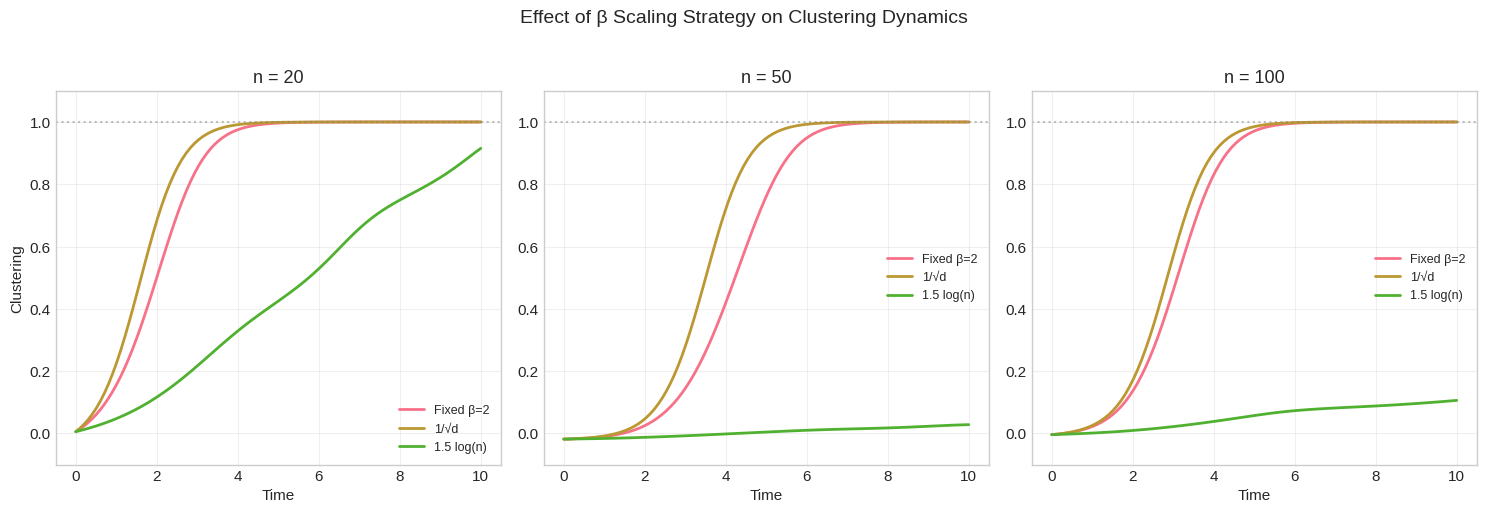

Observation: Log scaling maintains more controlled dynamics as n grows.


In [7]:
# Simulate dynamics with different scaling strategies

n_values = [20, 50, 100]
d = 10
t_end = 10.0

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, n in enumerate(n_values):
    X0 = random_sphere_points(n, d, seed=42)
    
    # Three strategies
    beta_fixed = 2.0
    beta_sqrt = 1.0 / np.sqrt(d)  # Standard transformer
    beta_log = 1.5 * np.log(n)  # Log scaling
    
    # Simulate (using simplified dynamics for speed)
    results = {}
    for name, beta in [('Fixed β=2', beta_fixed), ('1/√d', beta_sqrt), ('1.5 log(n)', beta_log)]:
        times, traj = simulate_sa(X0, beta, (0, t_end), n_steps=100)
        clustering = [compute_cluster_metric(traj[i]) for i in range(len(times))]
        results[name] = (times, clustering)
    
    ax = axes[idx]
    for name, (times, clustering) in results.items():
        ax.plot(times, clustering, linewidth=2, label=name)
    
    ax.axhline(y=1.0, color='gray', linestyle=':', alpha=0.5)
    ax.set_xlabel('Time', fontsize=11)
    ax.set_ylabel('Clustering' if idx == 0 else '', fontsize=11)
    ax.set_title(f'n = {n}', fontsize=13)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.1, 1.1)

plt.suptitle('Effect of β Scaling Strategy on Clustering Dynamics', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("Observation: Log scaling maintains more controlled dynamics as n grows.")

---

## 5. Interactive Exploration

In [ ]:
# Interactive exploration of long-context scaling

def explore_scaling(n, gamma, d):
    """Explore attention scaling with context length."""
    
    X = random_sphere_points(n, d, seed=42)
    
    # Compute critical gamma
    sims = pairwise_similarity_dist(X)
    rho = np.mean(sims)
    gamma_c = 1 / (1 - rho)
    
    # Compute β and attention
    beta = gamma * np.log(n)
    A = attention_weights(X, beta, normalized=True)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Weight distribution
    weights = A.flatten()
    axes[0].hist(weights, bins=50, density=True, alpha=0.7, edgecolor='black')
    axes[0].axvline(x=1/n, color='r', linestyle='--', label=f'1/n = {1/n:.4f}')
    axes[0].set_xlabel('Attention Weight')
    axes[0].set_ylabel('Density')
    axes[0].set_title(f'Weight Distribution (β = {beta:.2f})')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Attention matrix visualization
    im = axes[1].imshow(A[:20, :20], cmap='Blues', vmin=0)  # Show 20x20 submatrix
    axes[1].set_xlabel('Token j')
    axes[1].set_ylabel('Token i')
    axes[1].set_title('Attention Pattern (20x20 submatrix)')
    plt.colorbar(im, ax=axes[1], fraction=0.046)
    
    # Entropy distribution
    entropies = [attention_entropy(A[i]) for i in range(n)]
    axes[2].hist(entropies, bins=20, density=True, alpha=0.7, edgecolor='black')
    axes[2].axvline(x=np.mean(entropies), color='r', linestyle='--', 
                    label=f'Mean = {np.mean(entropies):.3f}')
    axes[2].set_xlabel('Attention Entropy')
    axes[2].set_ylabel('Density')
    axes[2].set_title('Entropy Distribution')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Regime classification
    if gamma < gamma_c * 0.8:
        regime = "SUBCRITICAL (uniform attention)"
    elif gamma > gamma_c * 1.2:
        regime = "SUPERCRITICAL (identity-like)"
    else:
        regime = "NEAR-CRITICAL (structured)"
    
    print(f"Parameters:")
    print(f"  n = {n}, d = {d}")
    print(f"  γ = {gamma:.2f}, β = γ log(n) = {beta:.2f}")
    print(f"  Critical γ_c = {gamma_c:.2f}")
    print(f"  Regime: {regime}")
    print(f"  Mean entropy: {np.mean(entropies):.3f}")

widgets.interact(
    explore_scaling,
    n=widgets.IntSlider(value=100, min=20, max=500, step=20, description='n:'),
    gamma=widgets.FloatSlider(value=1.0, min=0.2, max=3.0, step=0.1, description='γ:'),
    d=widgets.IntSlider(value=10, min=3, max=50, step=5, description='d:')
)

interactive(children=(IntSlider(value=100, description='n:', max=500, min=20, step=20), FloatSlider(value=1.0,…

<function __main__.explore_scaling(n, gamma, d)>

---

## Summary: Long-Context Phase Transition

### Key Results

| Aspect | Finding |
|--------|--------|
| **Problem** | Fixed β → uniform attention as n → ∞ |
| **Solution** | Scale β ~ log(n) |
| **Critical γ** | γ_c = 1/(1-ρ) |
| **Three regimes** | Subcritical, critical, supercritical |

### Practical Implications

1. **Standard transformers fail** for very long contexts with fixed β
2. **Log scaling maintains structure** as context grows
3. **Modern long-context models** implicitly or explicitly use this insight

### For Your Work

When processing many metabolites/entities simultaneously:
- Be aware of attention flattening
- Consider batch size and effective context length
- Models designed for short contexts may lose discriminative power on large knowledge graphs

---

## Next: Notebook 7 - Implications for Vector Databases

We'll synthesize all these theoretical insights and connect them to practical decisions in your biovector-eval work.